# Scenarios and sampling

## Load Profile

In [61]:
import sys

sys.path.append("../sddip")

In [62]:
import os
import random as rdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sddip import config

## Load Profile Manipulation

In [63]:
load_profile_name = "h0_summer_workday.txt"
load_profiles_dir = "supplementary/load_profiles"


load_profile_dir = os.path.join(config.test_cases_dir, load_profiles_dir)

load_profile_file = os.path.join(load_profile_dir, load_profile_name)

profile_df = pd.read_csv(load_profile_file, delimiter="\t")

profile_df

,time,h0
0,00:15:00,86.3
1,00:30:00,76.9
2,00:45:00,68.8
3,01:00:00,62.4
4,01:15:00,58.0
...,...,...
91,23:00:00,135.7
92,23:15:00,127.2
93,23:30:00,117.5
94,23:45:00,107.1


<AxesSubplot:>

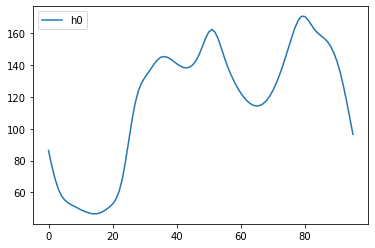

In [64]:
profile_df.plot()

<AxesSubplot:>

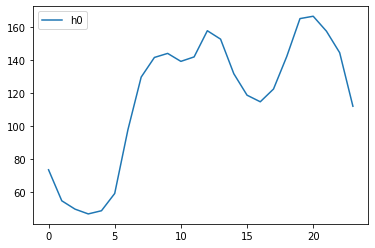

In [65]:
values = np.array(profile_df.h0.tolist())

reduction_factor = 4
if len(values) % reduction_factor != 0:
    raise ValueError(
        "Number of values to be reduced must be divisible by the reduction factor."
    )

reduced_values = np.mean(values.reshape(-1, reduction_factor), axis=1)

reduced_profile_df = pd.DataFrame({"h0": reduced_values})
reduced_profile_df.plot()

<AxesSubplot:>

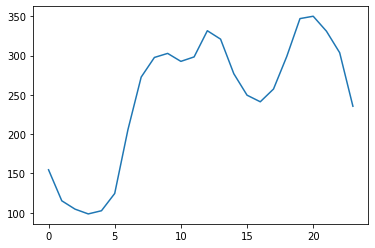

In [66]:
max_load = reduced_profile_df.h0.max()

scaling_factor = 350 / max_load

scaled_profile = reduced_profile_df.h0 * scaling_factor

scaled_profile.plot()

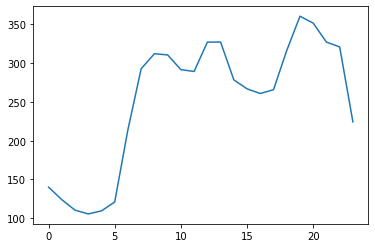

In [67]:
rdm_variation_profile = [
    p + p * rdm.uniform(-0.1, 0.1) for p in scaled_profile
]

plt.plot(rdm_variation_profile)

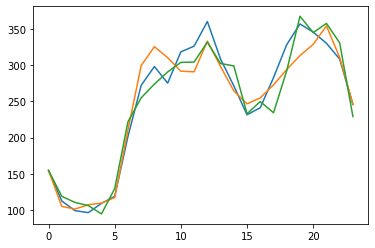

In [68]:
n_profiles = 3

profiles = [
    [p + p * rdm.uniform(-0.1, 0.1) for p in scaled_profile]
    for _ in range(n_profiles)
]

for profile in profiles:
    profile[0] = scaled_profile[0]

for i in range(n_profiles):
    plt.plot(profiles[i])

plt.show()

## Scenario generation

In [69]:
def get_rdm_variation(base_value, max_relative_variation=0.1):
    return base_value + base_value * rdm.uniform(
        -max_relative_variation, max_relative_variation
    )

In [70]:
n_buses = 2
demand_buses = [1]
no_demand_buses = [b for b in range(n_buses) if b not in demand_buses]

base_profile = scaled_profile

n_realizations_per_stage = 3
n_stages = len(base_profile)
n_total_ralizations = (n_stages - 1) * n_realizations_per_stage + 1

scenario_data = {"t": [], "n": [], "p": []}

demand_bus_keys = []
no_demand_bus_keys = []
for b in range(n_buses):
    bus_key = f"Pd{b+1}"
    scenario_data[bus_key] = []
    if b in demand_buses:
        demand_bus_keys.append(bus_key)
    else:
        scenario_data[bus_key] = [0] * n_total_ralizations
        no_demand_bus_keys.append(bus_key)


scenario_data["t"].append(1)
scenario_data["n"].append(1)
scenario_data["p"].append(1)

for db in demand_bus_keys:
    scenario_data[db].append(get_rdm_variation(base_profile[0]))


if n_stages < 2:
    raise ValueError("Number of stages must be greater than 1.")
if n_realizations_per_stage < 2:
    raise ValueError(
        "Number of realizations per stage must be greater than 1."
    )

for t in range(1, n_stages):
    for n in range(1, n_realizations_per_stage + 1):
        scenario_data["t"].append(t + 1)
        scenario_data["n"].append(n)
        scenario_data["p"].append(1 / n_realizations_per_stage)
        for db in demand_bus_keys:
            scenario_data[db].append(get_rdm_variation(base_profile[t]))


scenario_df = pd.DataFrame(scenario_data)
scenario_df

,t,n,p,Pd1,Pd2
0,1,1,1.000000,0,159.160031
1,2,1,0.333333,0,106.052538
2,2,2,0.333333,0,121.119931
3,2,3,0.333333,0,125.338410
4,3,1,0.333333,0,102.818534
...,...,...,...,...,...
65,23,2,0.333333,0,287.732068
66,23,3,0.333333,0,303.207077
67,24,1,0.333333,0,219.341635
68,24,2,0.333333,0,240.637887


## Sampling

In [71]:
n_samples = 2

samples = []
for _ in range(n_samples):
    sample = [
        rdm.randint(0, n_realizations_per_stage - 1)
        for _ in range(n_stages - 1)
    ]
    sample.insert(0, 0)
    samples.append(sample)

samples

[[0, 0, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 2, 1, 0, 2, 0, 0, 1, 2, 0, 0, 1, 1],
 [0, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0]]

## External Scenario Module

In [72]:
from sddip import scenarios

n_stages = 24
n_realizations_per_stage = 3

n_buses = 3
demand_buses = [1, 2]
max_value_targets = [350, 200]


sc_generator = scenarios.ScenarioGenerator(n_stages, n_realizations_per_stage)

scenario_df = sc_generator.generate_demand_scenario_dataframe(
    n_buses, demand_buses, max_value_targets, 0.2
)

scenario_df

,t,n,p,Pd1,Pd2,Pd3
0,1,1,1.000000,0,164.447108,76.599980
1,2,1,0.333333,0,105.466849,66.900100
2,2,2,0.333333,0,117.865905,76.789767
3,2,3,0.333333,0,129.919840,53.755072
4,3,1,0.333333,0,102.263014,65.244820
...,...,...,...,...,...,...
65,23,2,0.333333,0,264.724449,146.507969
66,23,3,0.333333,0,315.593031,161.295507
67,24,1,0.333333,0,228.049492,155.756784
68,24,2,0.333333,0,264.896347,134.244840


<AxesSubplot:>

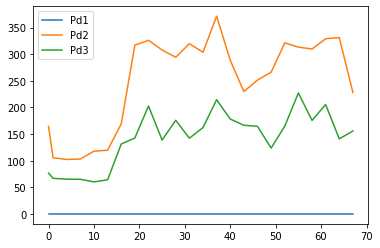

In [73]:
n = 1
realization_df = scenario_df[scenario_df["n"] == n]

profiles_df = realization_df.drop(["t", "n", "p"], axis=1)

profiles_df.plot()

In [74]:
n_samples = 3

sc_sampler = scenarios.ScenarioSampler(n_stages, n_realizations_per_stage)

sc_sampler.generate_samples(n_samples)

[[0, 2, 1, 1, 1, 2, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 2, 0, 0, 1],
 [0, 2, 0, 2, 2, 2, 1, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1, 2, 1, 0, 2, 0, 2, 0],
 [0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 2, 2, 0, 2, 2, 0, 2]]

<AxesSubplot:>

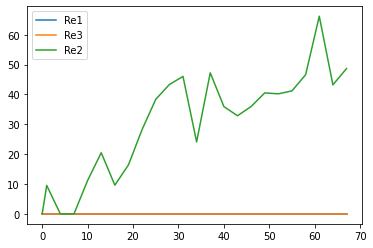

In [82]:
n = 1

re_profiles = sc_generator.generate_renewables_scenario_dataframe(
    3, [1], [0], [10], [0], [100], 0.2
)

re_profiles = re_profiles[re_profiles["n"] == n]

re_profiles.drop(["t", "n", "p"], axis=1, inplace=True)


re_profiles.plot()